# Homework 6.2 - Neural Networks and Deep Learning

**Sources**:

An [AutoEncoder](https://en.wikipedia.org/wiki/Autoencoder#:~:text=An%20autoencoder%20is%20a%20type,to%20ignore%20signal%20%E2%80%9Cnoise%E2%80%9D.) (AE) is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. Despite their numerous applications their implemention and theoretical background is pretty straightforward. Throughout this assignment you will implement an [MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron)-based AE to reconstruction hand-written digits of [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset. 

### Install & import the required packages
Install and import torch and torchvision (or any other package you think might come in handy).

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.model_selection import train_test_split

You're expected to use the MNIST dataset over the course of this assignment. After loading the train and test splits of the dataset, apply the required preprocessing procedures (zero center your input data). PyTorch provides convenient tools to automate this process.

In [37]:
df = pd.read_csv('train.csv')
trainX, testX, trainY, testY = train_test_split(df.iloc[:, 1:], df['label'], test_size=1/12, random_state=42)
trainX, validX, trainY, validY = train_test_split(trainX, trainY, test_size=1/7, random_state=42)

class Dataset(object):
    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
    
class DatasetMNIST(Dataset):
    def __init__(self, X):
        self.X = X
       
    def __len__(self):
        return len(self.X.index)
    
    def __getitem__(self, idx):
        image = torch.tensor(self.X.iloc[idx, ].values/255, dtype=torch.float32)      
        return image
    
train = DatasetMNIST(X = trainX)
valid_dataset = DatasetMNIST(X = validX)
train_loader = DataLoader(dataset=train, batch_size=64, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=64, shuffle=False)


### 1.1. Implement an MLP based Autoencoder
The architecture of your network should be symmetrical and have 2 hidden layers of sizes $h_1$ and $h_2$ with a latant size of $l$ while using [$ReLU$](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))s as nonlinearities. The following picture depicts a sample AE architecture for $h_1=4$ and $h_2=3$ and $l=2$ for the reconstruction of $1\times5$ inputs.

<img src="./ae.png">

The input to the network will be a minibatch of data, of shape
$(N, 28*28)$ where $N$ represents batch size. 

    Inputs of the forwardpass:
    - A batch of flated images (N, 28*28)

    outputs of the forwardpass:
    - reconstruction: reconstruction of the images.

In [29]:
class MLP_MNIST(nn.Module):
    def __init__(self, h1, h2, l):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(784, h1),
            nn.ReLU(),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Linear(h2, l),
        )
        self.decoder = nn.Sequential(
            nn.ReLU(),
            nn.Linear(l, h2),
            nn.ReLU(),
            nn.Linear(h2, h1),
            nn.ReLU(),
            nn.Linear(h1, 784),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        y = x
        x = self.decoder(x)
        return x, y

### 1.2. Train the model
Set up a basic training loop for your network. Use a Adam with no momentums to train your model. Use [L2](https://afteracademy.com/blog/what-are-l1-and-l2-loss-functions) as your objective function. Choose $N$ based on your available resources.

In [34]:
def basicT(model, optimizer, lossFunc, epochs):
    for j in range(epochs):
        model.train()
        train_losses = []
        valid_losses = []
        for i, (images) in enumerate(train_loader):
            x1, y1 = model.forward(images)
            target = x1
            loss = lossFunc(images, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        model.eval()
        with torch.no_grad():
            for i, (images) in enumerate(valid_loader):
                x1, y1 = model.forward(images)
                target = x1
                val.append(y1)
                loss = lossFunc(images, target)
                valid_losses.append(loss.item())
                
        mean_train_losses.append(np.mean(train_losses))
        mean_valid_losses.append(np.mean(valid_losses))


Train a model with $h_1=512$, $h_2=256$ and $l=5$, Train your model long enough so that you get the best results on the validation set.

In [8]:
mean_train_losses = []
mean_valid_losses = []
val = []
model = MLP_MNIST(512, 256, 5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lossFunc = nn.MSELoss()
basicT(model, optimizer, lossFunc, 10)

Plot the mean objective values for training and validation set on each epoch.

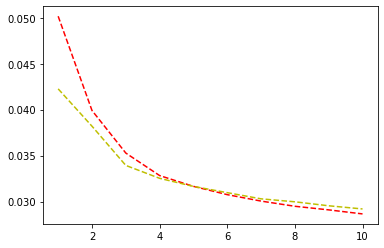

In [43]:
xP = []
for i in range(10):
 xP.append(i+1)
plt.plot(xP, mean_train_losses, 'r--', xP, mean_valid_losses, 'y--')
plt.show()

Visualize the best and worst reconstructions of test split. 

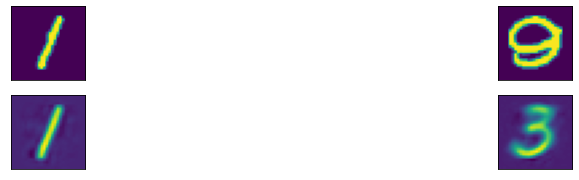

In [12]:
losses = []
model.eval()
test = torch.tensor(testX.values, dtype=torch.float32)/255

with torch.no_grad():
    preds = model(test)[0]

for i in range(len(test)):
    losses.append(lossFunc(test[i], preds[i]))
losses = np.asarray(losses)
indMax = np.argmax(losses)
indMin = np.argmin(losses)
sh = [indMin, indMax]
plt.figure(figsize=(16, 3))
x1 = -1
for i in sh:
    x1 += 1
    ax = plt.subplot(2, 2, x1 + 1)
    plt.imshow(test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, 2, x1 + 3)
    plt.imshow(preds[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Elaborate on how larger batchsizes can affect the training procedure and the final performance of the model? (2 pt)

بزرگتر شدن سایز بچ ها باعث میشود تا سرعت یادگیری مدل ما بیشتر شود ولی از طرفی جی پی یو به ما اجازه نمیدهد که داده ها از یک اندازه ای بزرگ تر باشند و هم اینکه بزرگ کردن بچ ها باعث میشود که مدل ما بیشتر اورفیت شود زیرا وقتی ما با بخشی از داده ها کار میکنم باعث میشود یک نویزی به میانگینی که میگیریم اضافه شود و محاسبات ما کمی نا دقیق تر شود. 

### 1.3. Investigation of different Latent sizes
By training your AE for $l=1$ to $l=7$ and visualizing the final train and validation reconstruction errors and sample outputs (for a fixed input), investigate the effects of lower and higher encoding latent spaces. 

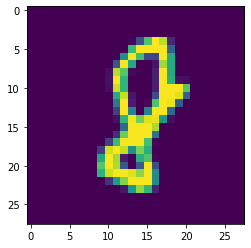

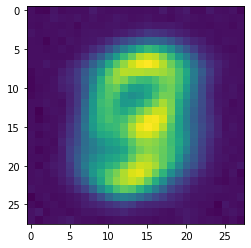

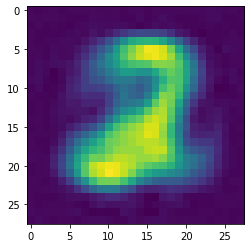

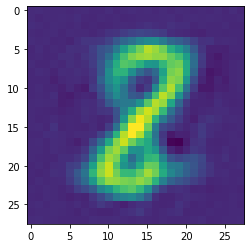

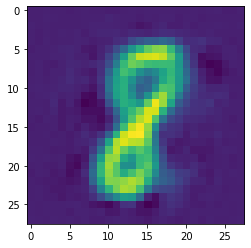

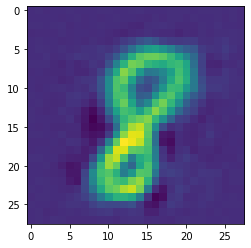

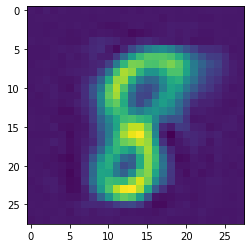

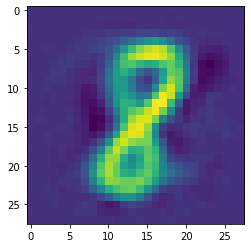

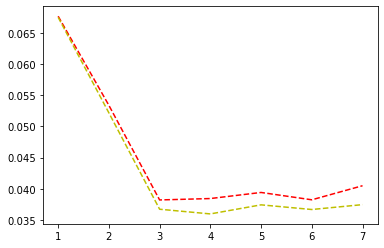

In [11]:
meanT = []
meanV = []
val = []
xP = []
lossFunc = nn.MSELoss()
plt.figure(figsize=(4,4))
plt.imshow(test[0].reshape(28, 28))

plt.show()
for i in range(1, 8):
    xP.append(i)
    mean_train_losses = []
    mean_valid_losses = []
    model = MLP_MNIST(512, 256, i)
    lossFunc = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    basicT(model, optimizer, lossFunc, 10)
    model.eval()
    with torch.no_grad():
        preds = model(test[0])[0]
    plt.imshow(preds.reshape(28, 28))
    plt.show()    
    meanT.append(np.mean(mean_train_losses))
    meanV.append(np.mean(mean_valid_losses))
plt.plot(xP, meanT, 'r--', xP, meanV, 'y--')
plt.show()

### 2. AE as a dimensionality reduction tool 
Plot the respective latent vectors of the validation images after training an AE with $l=2$. 

In [69]:
val = []
mean_train_losses = []
mean_valid_losses = []
model = MLP_MNIST(512, 256, 2)
lossFunc = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
basicT(model, optimizer, lossFunc, 10)

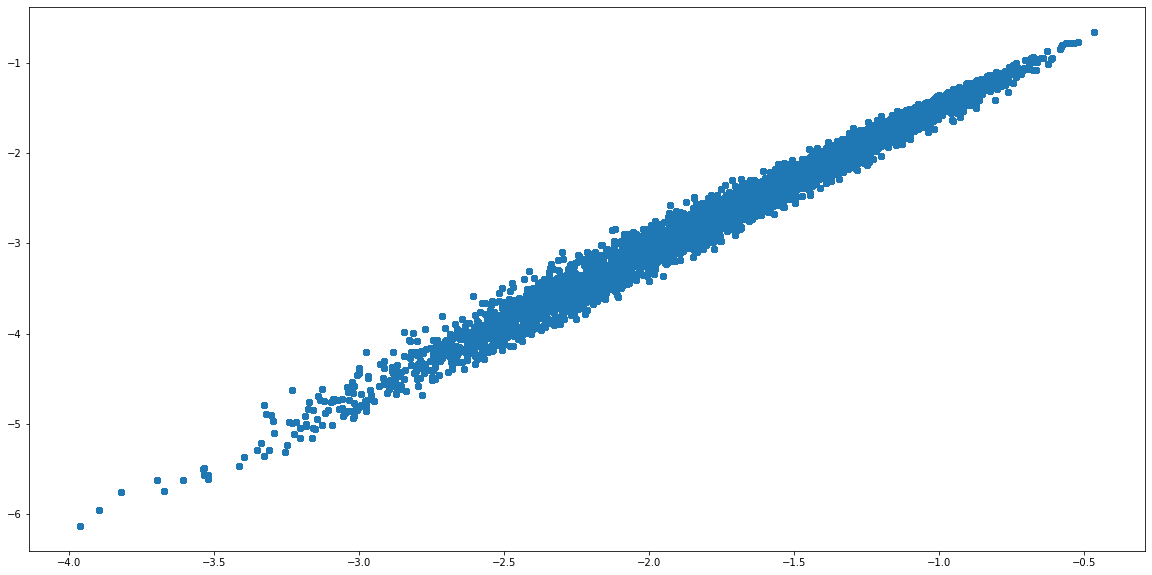

In [74]:
x = []
y = []
for i in range(len(val)):
    for j in range(len(val[i])):
        x.append(val[i][j][0])
        y.append(val[i][j][1])
x = np.asarray(x)
y = np.asarray(y)
fig = plt.figure(figsize=(20,10))
plt.scatter(x, y)
plt.show()